In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.signal import square
from scipy.integrate import quad
from numpy import sqrt, exp, pi, cos, sin, log
from scipy.stats import norm
from numba_stats import norm as norm_fast
import pandas as pd
from time import perf_counter
from tqdm import tqdm
from numba import njit
import polars as pl

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')
np.seterr(all = 'ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [4]:
@njit
def bs_put(S0, K, T, sigma, r):
    d1 = np.array((log(S0/K) + (r + sigma**2/2.) * T) / (sigma*sqrt(T))).reshape(1)
    d2 = d1 - sigma * sqrt(T)
    return K*exp(-r*T)*norm_fast.cdf(-d2, loc=0.0, scale=1.0) - S0*norm_fast.cdf(-d1, loc=0.0, scale=1.0)

@njit
def bs_call(S0, K, T, sigma, r):
    d1 = (log(S0/K) + (r + sigma**2/2.) * T) / (sigma*sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0*norm_fast.cdf(d1, loc=0.0, scale=1.0) - K*exp(-r*T)*norm_fast.cdf(d2, loc=0.0, scale=1.0)  

@njit
def Fourier_BS_Put(S0, K, T, sigma, r, N, zscore):
    _sigma, _T = max(.1, sigma), max(1, T)
    # if T < .5 or sigma > .2 : N = 256
    # if T < 1/12 : N = 512
    a = log(S0) + r * _T - zscore * _sigma * np.sqrt(_T) # Upper limit -12 std from the expected value
    b = log(S0) + r * _T + zscore * _sigma * np.sqrt(_T) # Lower limit -12 std from the expected value

    h       = lambda n : (n*pi) / (b-a) 
    g       = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
    g0      = K*(log(K) - a - 1) + exp(a)
    
    m       = log(S0) + (r - .5*sigma**2)*(T)
    bs_char = lambda u : exp(1j * u * m -0.5*(u**2 * sigma**2)*T)

    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*bs_char(h_n) * exp(-1j*a*h_n) * g(n)

    F = exp((-r*T))/(b-a) * np.real(F)
    return F if F > 0.0 else 0.0

In [114]:
import gc
# Generate grid

S  = 4400
r = .05

_T      = np.logspace(np.log10(1/365), np.log10(5), 20)
_K      = np.linspace(1, S*3, 25)
_sigma  = np.arange(0.1, 1, 0.05)

_z      = [12]
_N      = (2**np.arange(5, 12)).astype(int)
print(f'N Min:{_N.min()}, N Max:{_N.max()}')

shape = 0
for T, K, s in tqdm([(T, K, s) for T in _T for K in _K for s in _sigma]):
    for z, N in [(z, N) for z in _z for N in _N]:
        shape += 1

print(f'shape: {shape}')
error_df = {'S':np.full(shape, S,dtype=np.float16), 'K':np.empty(shape,dtype=np.float16), 'T':np.empty(shape,dtype=np.float16), 'sigma':np.empty(shape,dtype=np.float16), 'zscore':np.empty(shape,dtype=np.float16), 'N':np.empty(shape,dtype=np.float16), 'put_F':np.empty(shape), 'put_A':np.empty(shape)}
gc.collect()

idx = 0
for T, K, s in tqdm([(T, K, s) for T in _T for K in _K for s in _sigma]):
    for z, N in [(z, N) for z in _z for N in _N]:
        put_F = Fourier_BS_Put(S, K, T, s, r, N, z)
        put_A = bs_put(S, K, T, s, r)
        
        error_df['K'][idx] = K
        error_df['T'][idx] = T
        error_df['sigma'][idx] = s
        error_df['zscore'][idx] = z
        error_df['N'][idx] = N
        error_df['put_F'][idx] = put_F
        error_df['put_A'][idx] = put_A[0]
        idx += 1
    # print(error)
    
gc.collect()
pd.DataFrame(error_df)

N Min:32, N Max:2048


100%|██████████| 9000/9000 [00:00<00:00, 478189.23it/s]


shape: 63000


100%|██████████| 9000/9000 [00:01<00:00, 6737.42it/s]


,S,K,T,sigma,zscore,N,put_F,put_A
0,4400.0,1.0,0.002739,0.099976,12.0,32.0,477.423654,0.000000
1,4400.0,1.0,0.002739,0.099976,12.0,64.0,477.903083,0.000000
2,4400.0,1.0,0.002739,0.099976,12.0,128.0,477.851226,0.000000
3,4400.0,1.0,0.002739,0.099976,12.0,256.0,477.871436,0.000000
4,4400.0,1.0,0.002739,0.099976,12.0,512.0,477.871013,0.000000
...,...,...,...,...,...,...,...,...
62995,4400.0,13200.0,5.000000,0.950195,12.0,128.0,8424.164813,8424.164813
62996,4400.0,13200.0,5.000000,0.950195,12.0,256.0,8424.164813,8424.164813
62997,4400.0,13200.0,5.000000,0.950195,12.0,512.0,8424.164813,8424.164813
62998,4400.0,13200.0,5.000000,0.950195,12.0,1024.0,8424.164813,8424.164813


,K/S,T,sigma,RE,Error
1196,0.000227,1.029297,0.600098,0.0000,0.00
1019,0.625000,0.142578,0.150024,0.0000,0.00
1195,0.000227,1.029297,0.549805,0.0000,0.00
1197,0.000227,1.029297,0.649902,0.0000,0.00
904,0.625000,0.064697,0.150024,0.0000,0.00
...,...,...,...,...,...
3981,1.000000,0.064697,0.150024,0.0001,0.01
3980,1.000000,0.006039,0.449951,0.0001,0.01
3978,1.000000,0.006039,0.549805,0.0001,0.01
3056,0.750000,0.004066,0.750000,0.0001,0.01


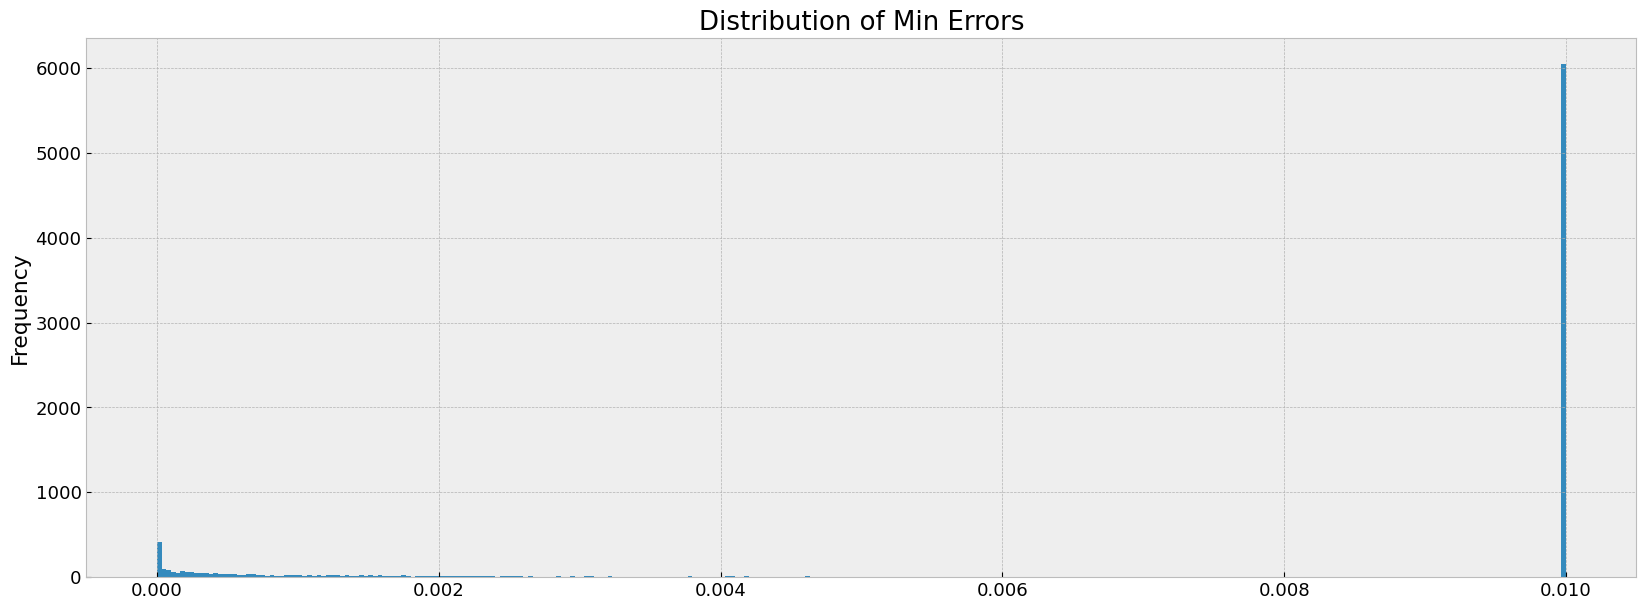

In [115]:
_MIN_ERROR = 0.01
_MIN_RE    = 0.0001

errors_df = (
    pl.from_dict(error_df)
    .with_columns([
         (pl.col('put_F') - pl.col('put_A')).abs().alias('Error')
        ,((pl.col('put_F') - pl.col('put_A'))/pl.col('put_A')).abs().alias('RE')
        ,(pl.col('K')/pl.col('S')).alias('K/S')
        ])
    .sort('Error')
    .groupby(['K/S', 'T', 'sigma'], maintain_order=True)
    .agg([
        pl.col('RE').max(),
        pl.col('Error').max()
    ])
    .with_columns([
        pl.when(pl.col('Error') == 0.0).then(0).otherwise(pl.col('RE')).alias('RE'),
    ])
    .with_columns([
        pl.when((pl.col('RE') == np.inf)).then(None).otherwise(pl.col('RE')).alias('RE')
    ])
    .with_columns([
        pl.when(pl.col('Error') > _MIN_ERROR).then(_MIN_ERROR).otherwise(pl.col('Error')).alias('Error'),
        pl.when(pl.col('RE')    > _MIN_RE   ).then(_MIN_RE).otherwise(pl.col('RE')).alias('RE'),
    ])
)
gc.collect()
errors_df.to_pandas()['Error'].plot.hist(bins=300, title='Distribution of Min Errors')
errors_df.to_pandas().sort_values('Error')
# errors_df

In [116]:
_df = (
    pl.from_dict(error_df)
    .with_columns([
         (pl.col('put_F') - pl.col('put_A')).abs().alias('Error')
        ,((pl.col('put_F') - pl.col('put_A'))/pl.col('put_A')).abs().alias('RE')
        ,(pl.col('K')/pl.col('S')).alias('K/S')
        ])
    .sort('Error')
    .groupby(['K/S', 'T', 'sigma'], maintain_order=True)
    .apply(
        lambda group_df: 
            group_df
            .filter(
                (pl.col('RE') >= 
                    (errors_df.filter((pl.col('K/S')== group_df.select(pl.col('K/S')).to_numpy()[0,0])
                    &(pl.col('T')== group_df.select(pl.col('T')).to_numpy()[0,0])
                    &(pl.col('sigma')== group_df.select(pl.col('sigma')).to_numpy()[0,0])).select(pl.col('RE'))[0,0])
                ) | 
                (pl.col('Error') >= 
                    (errors_df.filter((pl.col('K/S')== group_df.select(pl.col('K/S')).to_numpy()[0,0])
                    &(pl.col('T')== group_df.select(pl.col('T')).to_numpy()[0,0])
                    &(pl.col('sigma')== group_df.select(pl.col('sigma')).to_numpy()[0,0])).select(pl.col('Error'))[0,0])
                ))
            .filter(pl.col('Error') == pl.col('Error').min())
            .filter(pl.col('N')     == pl.col('N').min())
            .with_columns([
                pl.when((pl.col('RE') == np.inf)).then(None).otherwise(pl.col('RE')).alias('RE')
            ])
    )
)
_shape1 = _df.shape[0]
_df2 = (
    _df
    .filter((pl.col('Error')    > _MIN_ERROR))
    .filter((pl.col('RE')       > _MIN_RE))
    .to_pandas()
)
_df = _df.to_pandas()
_shape2 = _df.shape[0]

print(f'Reduction: {_shape2}/{_shape1} - {(_shape1-_shape2)/_shape1*100:.2f}%')
print(f"Error (Q99%):    {_df2['Error'].quantile(.99):.4f}")
print(f"Error (Q99.9%):  {_df2['Error'].quantile(.999):.4f}")
print(f"Error (Q99.99%): {_df2['Error'].quantile(.9999):.4f}")
print(f"RE (Q99%):    {_df2['RE'].dropna().quantile(.99):.4f}")
print(f"RE (Q99.9%):  {_df2['RE'].dropna().quantile(.999):.4f}")
print(f"RE (Q99.99%): {_df2['RE'].dropna().quantile(.9999):.4f}")
gc.collect()

fig = px.scatter_3d(_df, x='T', y='K/S', z='sigma', width=800, height=800, color='N', 
    title='Number of Fourier Terms over different T and sigma paramters', hover_data=['T', "sigma", 'N', 'K', 'Error', 'RE'],
    log_x=False)
fig.show()
gc.collect()
_df.sort_values('RE', ascending=False).head(25)

Reduction: 9000/9000 - 0.00%
Error (Q99%):    12.0178
Error (Q99.9%):  20.4580
Error (Q99.99%): 23.4282
RE (Q99%):    0.8732
RE (Q99.9%):  24.8925
RE (Q99.99%): 219.9588


,S,K,T,sigma,zscore,N,put_F,put_A,Error,RE,K/S
1908,4400.0,551.0,0.211792,0.700195,12.0,64.0,2.427534e-04,3.266373e-09,2.427501e-04,74317.940663,0.125227
1665,4400.0,1651.0,0.211792,0.350098,12.0,64.0,2.569786e-04,2.542581e-08,2.569532e-04,10105.997402,0.375227
2194,4400.0,2200.0,0.211792,0.250000,12.0,64.0,2.624591e-04,2.689438e-08,2.624322e-04,9757.883869,0.500000
1379,4400.0,1651.0,1.029297,0.150024,12.0,32.0,2.409728e-06,3.372534e-10,2.409390e-06,7144.153331,0.375227
1732,4400.0,1101.0,0.211792,0.500000,12.0,64.0,7.457289e-05,5.092910e-08,7.452196e-05,1463.249170,0.250227
2025,4400.0,551.0,0.692871,0.449951,12.0,32.0,6.263565e-04,8.094446e-07,6.255471e-04,772.810243,0.125227
1800,4400.0,551.0,3.367188,0.199951,12.0,32.0,2.857138e-05,3.770808e-08,2.853367e-05,756.699109,0.125227
1999,4400.0,1101.0,0.064697,0.899902,12.0,128.0,3.177577e-05,5.130633e-08,3.172446e-05,618.334303,0.250227
1474,4400.0,1651.0,0.064697,0.649902,12.0,128.0,5.454978e-05,9.555922e-08,5.445422e-05,569.847912,0.375227
2012,4400.0,551.0,1.029297,0.350098,12.0,32.0,3.439929e-05,8.449576e-08,3.431480e-05,406.112638,0.125227


In [101]:
# Z: 6
Error (Q99%):    0.4252
Error (Q99.9%):  0.7463
Error (Q99.99%): 1.6771
RE (Q99%):    0.0227
RE (Q99.9%):  0.1481
RE (Q99.99%): 0.9895

# Z: 7
Error (Q99%):    0.6101
Error (Q99.9%):  0.9775
Error (Q99.99%): 1.0801
RE (Q99%):    0.0423
RE (Q99.9%):  0.6820
RE (Q99.99%): 0.9866

# Z: 8
Error (Q99%):    0.5322
Error (Q99.9%):  0.9128
Error (Q99.99%): 1.0536
RE (Q99%):    0.0445
RE (Q99.9%):  0.5263
RE (Q99.99%): 0.9403

# Z: 12
Error (Q99%):    0.7474
Error (Q99.9%):  1.7275
Error (Q99.99%): 2.9217
RE (Q99%):    0.0467
RE (Q99.9%):  0.5349
RE (Q99.99%): 0.9374



SyntaxError: invalid syntax (1217289859.py, line 2)

In [74]:
from scipy.interpolate import RBFInterpolator
X = _df[['K/S', 'sigma', 'T']].values
Y = _df[['N']].values
interpolator = RBFInterpolator(X, Y, smoothing=3)#, kernel='linear') 
y = interpolator(X)

print(f'MAE: {np.mean(np.abs(Y-y))}')
_df2 = np.concatenate((X, y), axis=1)
_df2 = pd.DataFrame(_df2, columns=['K/S', 'sigma', 'T', 'N'])

gc.collect()
fig = px.scatter_3d(_df2, x='T', y='K/S', z='sigma', width=800, height=800, color='N', 
    title='Number of Fourier Terms over different T and sigma paramters',
    log_x=True)
fig.show()
gc.collect()

%timeit interpolator(X[[0]])

MAE: 20.41110289126256


49.1 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
